# Exercise: Optimizing Full Computer Vision Pipeline

In this exercise, we'll classify fashion items with support vector machines in scikit-learn. We will now wrap OpenCV in a custom scikit-learn transformer to combine OpenCV's computer vision methods with scikit-learns powerful pipeline functionalities. 

Your tasks are the following:

- Optimize the whole computer vision pipeline using grid search and cross validation
- Evaluate the best model

In [17]:
# imports
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Acquisition and Preprocessing

In [18]:
# load the MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [19]:
# load the training and test data
X_train, y_train = load_mnist('../../images/fashion', kind='train')
X_test, y_test = load_mnist('../../images/fashion', kind='t10k')

In [20]:
# shuffle data
idx = np.arange(len(X_train))
np.random.shuffle(idx)

# we'll only use 10% of the data for speed-up
X_train = X_train[:int(.10*len(idx))]
y_train = y_train[:int(.10*len(idx))]

In [21]:
# store the labels
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

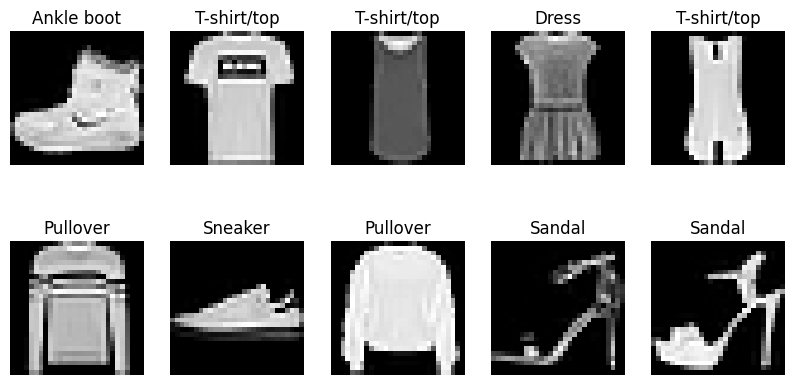

In [22]:
# plot the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax[i//5, i%5].imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(classes[y_train[i]])

## 2. Train a Support Vector Machine for Image Classification

In [23]:
# Fit a support vector machine to the data
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [24]:
# Predict the labels of the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

Accuracy: 0.80


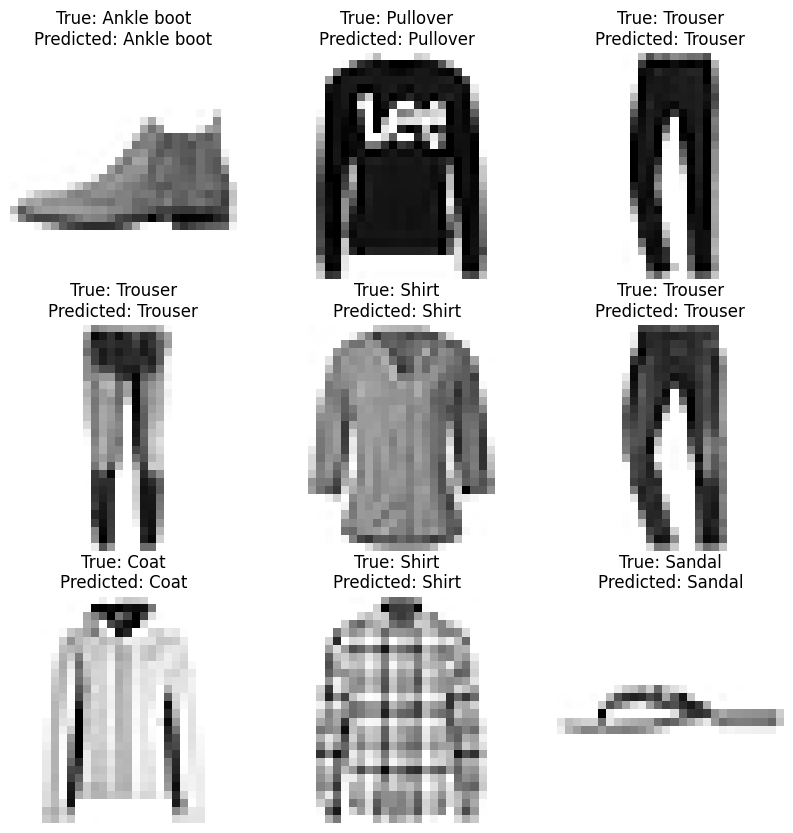

In [25]:
# plot some images and their predicted and true labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='binary')
    ax.set_title('True: %s\nPredicted: %s' % (classes[y_test[i]], classes[y_pred[i]]))
    ax.axis('off')

## 3. Using OpenCV within Scikit-Learn-Pipelines

In [26]:
# implement a custom transformer that extracts HOG features from the images

import cv2

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class OpenCVFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_type='hog'):
        self.feature_type = feature_type

    def fit(self, X, y=None):
        return self  # nothing to fit

    def transform(self, X):
        # X shape is (n_samples, 784) for Fashion MNIST
        # We need to reshape to (n_samples, 28, 28) first
        X_images = X.reshape(-1, 28, 28)
        features = []
        
        for image in X_images:
            # Convert to uint8 for OpenCV
            image = (image * 255).astype(np.uint8)
            
            if self.feature_type == 'hog':
                # Calculate HOG features
                winSize = (28, 28)
                blockSize = (14, 14)
                blockStride = (7, 7)
                cellSize = (7, 7)
                nbins = 9
                hog = cv2.HOGDescriptor(winSize, blockSize, 
                                      blockStride, cellSize, nbins)
                feature = hog.compute(image)
                
            elif self.feature_type == 'edges':
                # Calculate edge features using Canny
                edges = cv2.Canny(image, 50, 150)
                feature = edges.flatten()
            
            features.append(feature.flatten())
            
        return np.array(features)


In [27]:
# Create a pipeline with the custom transformer and SVM
pipeline = Pipeline([
    ('features', OpenCVFeatureExtractor(feature_type='hog')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

In [28]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy_custom_pipeline = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy_custom_pipeline)

Accuracy: 0.78


## 4. Optimizing the Full Computer Vision Pipeline

**TODO**: Fine-tune your model using grid search over the whole pipeline. Optimize over the SVM parameters from the last exercise as well as the extracted OpenCV features - all in one shot!

In [29]:
# print all parameters that can be tuned using grid search
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'scaler', 'svm', 'features__feature_type', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [30]:
from sklearn.model_selection import GridSearchCV

# Optimize over 2x2x2x4=32 combinations of hyperparameters
param_grid = {
    'features__feature_type': ['hog', 'edges'], # try HOG and edge features 
    'svm__C': [1, 10], # Regularization parameter
    'svm__gamma': [0.0001, 0.001], # Kernel coefficient
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'] } # Kernel type

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.799 total time=   3.4s
[CV 2/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.783 total time=   4.3s
[CV 3/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.790 total time=   4.1s
[CV 4/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.810 total time=   4.5s
[CV 5/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.787 total time=   4.9s
[CV 1/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=rbf;, score=0.787 total time=   6.9s
[CV 2/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=rbf;, score=0.786 total time=   5.2s
[CV 3/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=rbf;, sc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features', OpenCVFeatureExtractor()),
                                       ('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             param_grid={'features__feature_type': ['hog', 'edges'],
                         'svm__C': [1, 10], 'svm__gamma': [0.0001, 0.001],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=3)

**TODO**: Retrieve the best model from the grid search and calculate the final accuracy on the test data! Which features should OpenCV extract?

In [31]:
# retrieve the best parameters
grid_search.best_params_

{'features__feature_type': 'hog',
 'svm__C': 10,
 'svm__gamma': 0.001,
 'svm__kernel': 'rbf'}

In [32]:
# retrain the best model on the full training set
final_model = grid_search.best_estimator_.fit(X_train, y_train)

# calculate the final accuracy of the best model
y_pred_best = final_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print('Final accuracy:', accuracy_best)

Final accuracy: 0.8391


**ANSWER:** 